## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"           
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/tmp3/csam11000/cs231n/assignment1/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    # shape of a1 = [N, (32-7)/2 +1 = 13, 13, 32]
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    # shape of h1_flat = [N, 5408]
    y_out = tf.matmul(h1_flat,W1) + b1
    # shape of y_out = [N, 10]
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 11.4 and accuracy of 0.031
Iteration 100: with minibatch training loss = 1.14 and accuracy of 0.22
Iteration 200: with minibatch training loss = 0.745 and accuracy of 0.22
Iteration 300: with minibatch training loss = 0.524 and accuracy of 0.28
Iteration 400: with minibatch training loss = 0.565 and accuracy of 0.39
Iteration 500: with minibatch training loss = 0.574 and accuracy of 0.31
Iteration 600: with minibatch training loss = 0.476 and accuracy of 0.38
Iteration 700: with minibatch training loss = 0.441 and accuracy of 0.41
Epoch 1, Overall loss = 0.764 and accuracy of 0.301


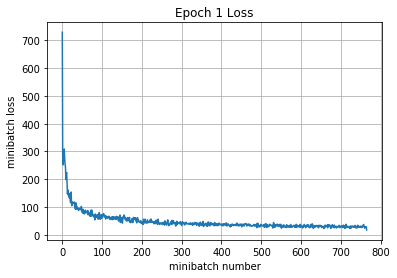

Validation
Epoch 1, Overall loss = 0.43 and accuracy of 0.379


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    Wconv1 = tf.get_variable(name='Wconv1', shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable(name='bconv1', shape=[32])
    W1 = tf.get_variable(name='W1', shape=[5408, 1024])
    b1 = tf.get_variable(name='b1', shape=[1024])
    W2 = tf.get_variable(name='W2', shape=[1024, 10])
    b2 = tf.get_variable(name='b2', shape=[10])
    
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    bn1 = tf.contrib.layers.batch_norm(h1, center=True, scale=True, is_training=is_training)
    maxpool1 = tf.nn.max_pool(bn1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    maxpool1_flat = tf.reshape(maxpool1, [-1, 5408])
    a2 = tf.matmul(maxpool1_flat, W1) + b1
    h2 = tf.nn.relu(a2)
    y_out = tf.matmul(h2, W2) + b2
    
    return y_out
y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    # only if we set os.environ["CUDA_VISIBLE_DEVICES"]=blank
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

100 loops, best of 3: 3.71 ms per loop
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

100 loops, best of 3: 3.6 ms per loop


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [8]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.RMSPropOptimizer(1e-3)



In [9]:
# batch normalization in tensorflow requires this extra dependency
# When is_training is True the moving_mean and moving_variance need to be updated, 
# by default the update_ops are placed in tf.GraphKeys.UPDATE_OPS 
# so they need to be added as a dependency to the train_step
# reference: http://ruishu.io/2016/12/27/batchnorm/
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    # Ensures that we execute the update moving average operation before perform train_step
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 2.95 and accuracy of 0.14
Iteration 100: with minibatch training loss = 2.03 and accuracy of 0.39
Iteration 200: with minibatch training loss = 1.7 and accuracy of 0.47
Iteration 300: with minibatch training loss = 1.67 and accuracy of 0.53
Iteration 400: with minibatch training loss = 1.79 and accuracy of 0.41
Iteration 500: with minibatch training loss = 1.21 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.42 and accuracy of 0.45
Iteration 700: with minibatch training loss = 1.09 and accuracy of 0.62
Epoch 1, Overall loss = 1.68 and accuracy of 0.452


(1.6834215260525138, 0.45159183673469389)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [11]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.84 and accuracy of 0.452


(1.8379914026260376, 0.45200000000000001)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [24]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    # [conv-relu-pool]xN -> [affine]xM -> dropout -> [softmax or SVM]
    N=5
    
    for i in range(N):
        # Convolutional layer
        conv = tf.layers.conv2d(
            inputs=X,
            filters=(i+1)*32,
            kernel_size=3,
            padding='same',
            activation=tf.nn.relu
        )
        
        # Pooling layer
        pool = tf.layers.max_pooling2d(inputs=conv, pool_size=2, strides=2)
        
        X=pool
        
    # Affine layer
    pool_flat = tf.reshape(pool, [-1, 1*1*160])
    dense1 = tf.layers.dense(inputs=pool_flat, units=1024)
    dropout = tf.layers.dropout(
        inputs=dense1, rate=0.5, training=is_training)
    
    
    # Logits layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    return logits



In [34]:
# Feel free to play with this cell

def my_model_2(X,y,is_training):
    #[batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
    N=2
    
    for i in range(N):
        # Convolutional layer
        bn = tf.layers.batch_normalization(inputs=X, training=is_training)
        h = tf.nn.relu(bn)
        conv = tf.layers.conv2d(
            inputs=h,
            filters=(i+1)*32,
            kernel_size=3,
            padding='same',
            activation=tf.nn.relu
        )
        
        
        X=conv
        
    # Pooling layer
    pool = tf.layers.max_pooling2d(inputs=conv, pool_size=2, strides=2)
        
    # Affine layer ([ dense -> relu -> batchnorm ]) 
    pool_flat = tf.reshape(pool, [-1, 16*16*64])
    dense1 = tf.layers.dense(inputs=pool_flat, units=1024, activation=tf.nn.relu)
    bn_affine = tf.layers.batch_normalization(dense1, training=is_training)
    dropout = tf.layers.dropout(
        inputs=bn_affine, rate=0.5, training=is_training)
    
    
    # Logits layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    
    
    return logits



In [49]:
# Feel free to play with this cell

def my_model_3(X,y,is_training):
    #[conv-relu-batchnorm]xN -> [affine]xM -> [softmax or SVM]
    N=2
    
    for i in range(N):
        # Convolutional layer
        
        conv = tf.layers.conv2d(
            inputs=X,
            filters=(i+1)*32,
            kernel_size=3,
            padding='same',
            activation=tf.nn.relu
        )
        bn = tf.layers.batch_normalization(inputs=conv, training=is_training)
        
        X=bn
        
    # Pooling layer
    pool = tf.layers.max_pooling2d(inputs=bn, pool_size=2, strides=2)
        
    # Affine layer ([ dense -> relu -> batchnorm ->dropout ] ) 
    pool_flat = tf.reshape(pool, [-1, 16*16*64])
    dense1 = tf.layers.dense(inputs=pool_flat, units=1024, activation=tf.nn.relu)
    bn_affine = tf.layers.batch_normalization(dense1, training=is_training)
    dropout = tf.layers.dropout(
        inputs=bn_affine, rate=0.3, training=is_training)
    
    
    # Logits layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    
    
    return logits


In [63]:
# Resnet model
# reference to: https://arxiv.org/pdf/1603.05027.pdf
def resUnit(input_layer, i):
    with tf.variable_scope('res_unit' + str(i)):
        part1 = tf.layers.batch_normalization(input_layer, training=is_training)
        part2 = tf.nn.relu(part1)
        part3 =  tf.layers.conv2d(part2, filters=64, kernel_size=3, padding='same', activation=None)
        part4 = tf.layers.batch_normalization(part3, training=is_training)
        part5 = tf.nn.relu(part4)
        part6 =  tf.layers.conv2d(part5, filters=64, kernel_size=3, padding='same', activation=None)
        
        output = part6 + input_layer
        return output
    
def resnet(X, y , is_training):
    total_layers = 25
    units_between_strides = 5
    total_strided_block = total_layers // units_between_strides        

    layer1 = tf.layers.conv2d(
        inputs=X,
        filters=64,
        kernel_size=3,
        padding='same',
        activation=tf.nn.relu
    )
    layer1 = tf.layers.batch_normalization(layer1, training=is_training, name='conv_0')

    for i in range(total_strided_block):
        for j in range(units_between_strides):
            # resnet block
            layer1 = resUnit(layer1, (i*total_strided_block + j))
            
        # stride convolution layer   
        layer1 = tf.layers.conv2d(layer1, filters=64, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        layer1 = tf.layers.batch_normalization(layer1, training=is_training,  name='conv_s_'+str(i))
        
    top = tf.layers.conv2d(layer1, filters=10, kernel_size=3, padding='same')
    top = tf.layers.batch_normalization(top, training=is_training,  name='conv_top')
    
    top_flat = tf.contrib.layers.flatten(top)
    
    return top_flat

In [71]:
def highwayUnit(input_layer, i):
    with tf.variable_scope('highway_unit' + str(i)):
      
        H =  tf.layers.conv2d(input_layer, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
        # set bias to -1 or -3 ...in order to push input to run through short cut path
        T =  tf.layers.conv2d(input_layer, filters=64, kernel_size=3, padding='same', activation=tf.nn.sigmoid, bias_initializer=tf.constant_initializer(-1))
        
        output = H*T + (1-T) * input_layer
        return output
    
def Highwaynet(X, y , is_training):
    total_layers = 25
    units_between_strides = 5
    total_strided_block = total_layers // units_between_strides        

    layer1 = tf.layers.conv2d(
        inputs=X,
        filters=64,
        kernel_size=3,
        padding='same',
        activation=tf.nn.relu
    )
    layer1 = tf.layers.batch_normalization(layer1, training=is_training, name='conv_0')

    for i in range(total_strided_block):
        for j in range(units_between_strides):
            # highwaynet block
            layer1 = highwayUnit(layer1, (i*total_strided_block + j))
            
        # stride convolution layer   
        layer1 = tf.layers.conv2d(layer1, filters=64, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        layer1 = tf.layers.batch_normalization(layer1, training=is_training,  name='conv_s_'+str(i))
        
    top = tf.layers.conv2d(layer1, filters=10, kernel_size=3, padding='same')
    top = tf.layers.batch_normalization(top, training=is_training,  name='conv_top')
    
    top_flat = tf.contrib.layers.flatten(top)
    
    return top_flat

In [83]:
def denseUnit(input_layer, i, j):
    with tf.variable_scope('Dense_unit' + str(i)):
      
        a =  tf.layers.conv2d(input_layer, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
        a = tf.layers.batch_normalization(a, training=is_training)
        nodes=[]
        nodes.append(a)
        
        for _ in range(j):
            b =  tf.layers.conv2d(tf.concat(a, axis=3), filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
            b = tf.layers.batch_normalization(b, training=is_training)
            nodes.append(b)
            
        return b
    
def Densenet(X, y , is_training):
    total_layers = 25
    units_between_strides = 5
    total_strided_block = total_layers // units_between_strides        

    layer1 = tf.layers.conv2d(
        inputs=X,
        filters=64,
        kernel_size=3,
        padding='same',
        activation=tf.nn.relu
    )
    layer1 = tf.layers.batch_normalization(layer1, training=is_training, name='conv_0')

    for i in range(total_strided_block):
        layer1 = denseUnit(layer1, i, units_between_strides)
            
        # stride convolution layer   
        layer1 = tf.layers.conv2d(layer1, filters=64, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        layer1 = tf.layers.batch_normalization(layer1, training=is_training,  name='conv_s_'+str(i))
        
    top = tf.layers.conv2d(layer1, filters=10, kernel_size=3, padding='same')
    top = tf.layers.batch_normalization(top, training=is_training,  name='conv_top')
    
    top_flat = tf.contrib.layers.flatten(top)
    
    return top_flat

In [19]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.AdamOptimizer()


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 12.2 and accuracy of 0.078
Iteration 100: with minibatch training loss = 1.79 and accuracy of 0.3
Iteration 200: with minibatch training loss = 1.59 and accuracy of 0.48
Iteration 300: with minibatch training loss = 1.43 and accuracy of 0.42
Iteration 400: with minibatch training loss = 1.55 and accuracy of 0.41
Iteration 500: with minibatch training loss = 1.43 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.57 and accuracy of 0.45
Iteration 700: with minibatch training loss = 1.39 and accuracy of 0.55
Epoch 1, Overall loss = 1.54 and accuracy of 0.455


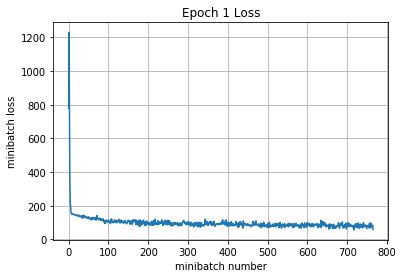

Iteration 800: with minibatch training loss = 0.975 and accuracy of 0.62
Iteration 900: with minibatch training loss = 1.05 and accuracy of 0.66
Iteration 1000: with minibatch training loss = 1.12 and accuracy of 0.64
Iteration 1100: with minibatch training loss = 1.22 and accuracy of 0.53
Iteration 1200: with minibatch training loss = 1.04 and accuracy of 0.62
Iteration 1300: with minibatch training loss = 1.35 and accuracy of 0.53
Iteration 1400: with minibatch training loss = 1.39 and accuracy of 0.56
Iteration 1500: with minibatch training loss = 1.12 and accuracy of 0.59
Epoch 2, Overall loss = 1.14 and accuracy of 0.599


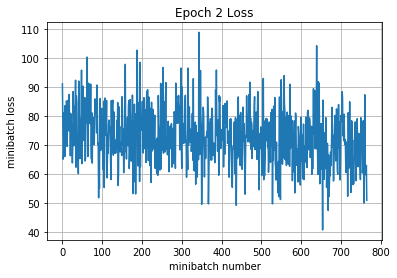

Iteration 1600: with minibatch training loss = 0.99 and accuracy of 0.66
Iteration 1700: with minibatch training loss = 0.964 and accuracy of 0.62
Iteration 1800: with minibatch training loss = 0.831 and accuracy of 0.77
Iteration 1900: with minibatch training loss = 0.732 and accuracy of 0.75
Iteration 2000: with minibatch training loss = 1.1 and accuracy of 0.55
Iteration 2100: with minibatch training loss = 0.915 and accuracy of 0.64
Iteration 2200: with minibatch training loss = 0.634 and accuracy of 0.8
Epoch 3, Overall loss = 0.998 and accuracy of 0.655


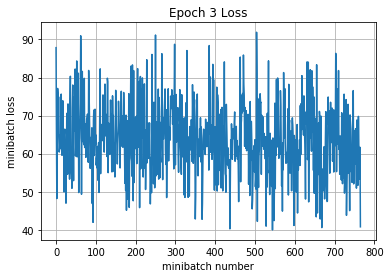

Iteration 2300: with minibatch training loss = 0.716 and accuracy of 0.78
Iteration 2400: with minibatch training loss = 0.622 and accuracy of 0.84
Iteration 2500: with minibatch training loss = 0.937 and accuracy of 0.7
Iteration 2600: with minibatch training loss = 1.04 and accuracy of 0.62
Iteration 2700: with minibatch training loss = 0.981 and accuracy of 0.72
Iteration 2800: with minibatch training loss = 0.904 and accuracy of 0.69
Iteration 2900: with minibatch training loss = 0.902 and accuracy of 0.73
Iteration 3000: with minibatch training loss = 1.3 and accuracy of 0.62
Epoch 4, Overall loss = 0.916 and accuracy of 0.684


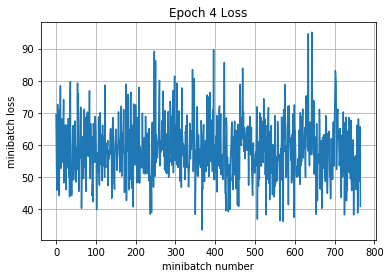

Iteration 3100: with minibatch training loss = 1.01 and accuracy of 0.62
Iteration 3200: with minibatch training loss = 0.903 and accuracy of 0.62
Iteration 3300: with minibatch training loss = 0.815 and accuracy of 0.72
Iteration 3400: with minibatch training loss = 0.887 and accuracy of 0.72
Iteration 3500: with minibatch training loss = 0.741 and accuracy of 0.69
Iteration 3600: with minibatch training loss = 0.758 and accuracy of 0.73
Iteration 3700: with minibatch training loss = 1 and accuracy of 0.67
Iteration 3800: with minibatch training loss = 0.981 and accuracy of 0.67
Epoch 5, Overall loss = 0.845 and accuracy of 0.71


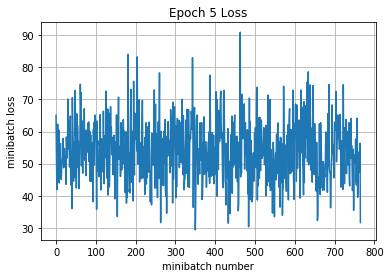

Iteration 3900: with minibatch training loss = 0.788 and accuracy of 0.73
Iteration 4000: with minibatch training loss = 0.914 and accuracy of 0.72
Iteration 4100: with minibatch training loss = 0.903 and accuracy of 0.7
Iteration 4200: with minibatch training loss = 0.818 and accuracy of 0.77
Iteration 4300: with minibatch training loss = 0.696 and accuracy of 0.73
Iteration 4400: with minibatch training loss = 0.798 and accuracy of 0.7
Iteration 4500: with minibatch training loss = 0.739 and accuracy of 0.78
Epoch 6, Overall loss = 0.802 and accuracy of 0.727


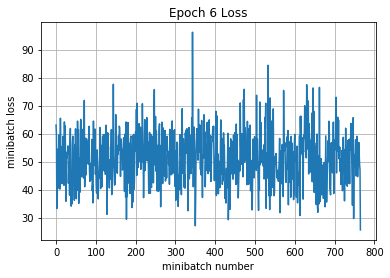

Iteration 4600: with minibatch training loss = 1.13 and accuracy of 0.62
Iteration 4700: with minibatch training loss = 0.764 and accuracy of 0.8
Iteration 4800: with minibatch training loss = 0.933 and accuracy of 0.64
Iteration 4900: with minibatch training loss = 0.881 and accuracy of 0.66
Iteration 5000: with minibatch training loss = 0.947 and accuracy of 0.75
Iteration 5100: with minibatch training loss = 1.04 and accuracy of 0.7
Iteration 5200: with minibatch training loss = 0.586 and accuracy of 0.84
Iteration 5300: with minibatch training loss = 0.97 and accuracy of 0.72
Epoch 7, Overall loss = 0.752 and accuracy of 0.744


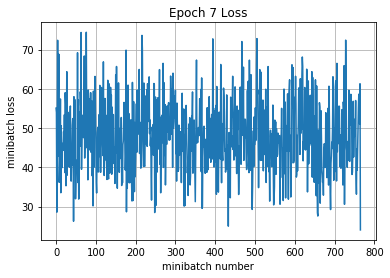

Iteration 5400: with minibatch training loss = 0.413 and accuracy of 0.83
Iteration 5500: with minibatch training loss = 0.773 and accuracy of 0.73
Iteration 5600: with minibatch training loss = 0.684 and accuracy of 0.73
Iteration 5700: with minibatch training loss = 0.538 and accuracy of 0.81
Iteration 5800: with minibatch training loss = 0.539 and accuracy of 0.78
Iteration 5900: with minibatch training loss = 0.882 and accuracy of 0.7
Iteration 6000: with minibatch training loss = 0.836 and accuracy of 0.7
Iteration 6100: with minibatch training loss = 0.686 and accuracy of 0.8
Epoch 8, Overall loss = 0.721 and accuracy of 0.754


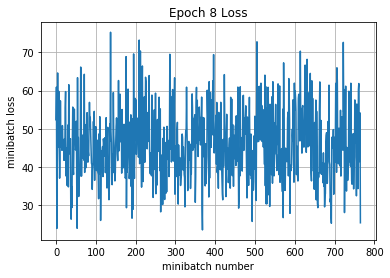

Iteration 6200: with minibatch training loss = 0.635 and accuracy of 0.78
Iteration 6300: with minibatch training loss = 0.579 and accuracy of 0.83
Iteration 6400: with minibatch training loss = 0.527 and accuracy of 0.84
Iteration 6500: with minibatch training loss = 0.863 and accuracy of 0.67
Iteration 6600: with minibatch training loss = 0.667 and accuracy of 0.78
Iteration 6700: with minibatch training loss = 0.891 and accuracy of 0.77
Iteration 6800: with minibatch training loss = 0.704 and accuracy of 0.77
Epoch 9, Overall loss = 0.684 and accuracy of 0.767


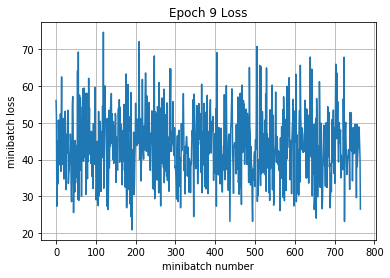

Iteration 6900: with minibatch training loss = 0.636 and accuracy of 0.83
Iteration 7000: with minibatch training loss = 0.607 and accuracy of 0.78
Iteration 7100: with minibatch training loss = 0.557 and accuracy of 0.8
Iteration 7200: with minibatch training loss = 0.537 and accuracy of 0.8
Iteration 7300: with minibatch training loss = 0.717 and accuracy of 0.81
Iteration 7400: with minibatch training loss = 0.879 and accuracy of 0.72
Iteration 7500: with minibatch training loss = 0.769 and accuracy of 0.69
Iteration 7600: with minibatch training loss = 1.2 and accuracy of 0.61
Epoch 10, Overall loss = 0.671 and accuracy of 0.772


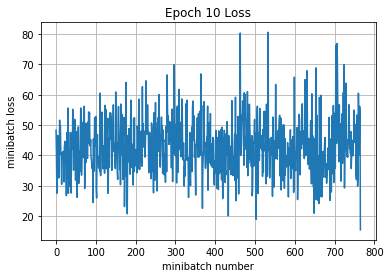

Validation
Epoch 1, Overall loss = 1.04 and accuracy of 0.687


(1.0367615504264831, 0.68700000000000006)

In [20]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 3.86 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.81 and accuracy of 0.31
Iteration 200: with minibatch training loss = 1.6 and accuracy of 0.36
Iteration 300: with minibatch training loss = 1.63 and accuracy of 0.47
Iteration 400: with minibatch training loss = 1.52 and accuracy of 0.44
Iteration 500: with minibatch training loss = 1.4 and accuracy of 0.59
Iteration 600: with minibatch training loss = 1.22 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.3 and accuracy of 0.55
Epoch 1, Overall loss = 1.63 and accuracy of 0.454


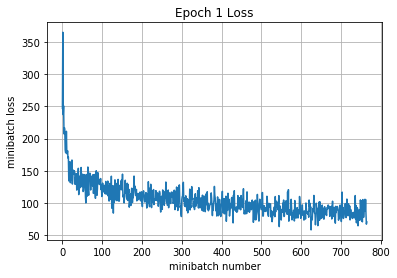

Iteration 800: with minibatch training loss = 1.17 and accuracy of 0.58
Iteration 900: with minibatch training loss = 1.14 and accuracy of 0.67
Iteration 1000: with minibatch training loss = 1.27 and accuracy of 0.53
Iteration 1100: with minibatch training loss = 1.45 and accuracy of 0.47
Iteration 1200: with minibatch training loss = 1.08 and accuracy of 0.67
Iteration 1300: with minibatch training loss = 1.16 and accuracy of 0.62
Iteration 1400: with minibatch training loss = 1.12 and accuracy of 0.59
Iteration 1500: with minibatch training loss = 1.07 and accuracy of 0.52
Epoch 2, Overall loss = 1.19 and accuracy of 0.585


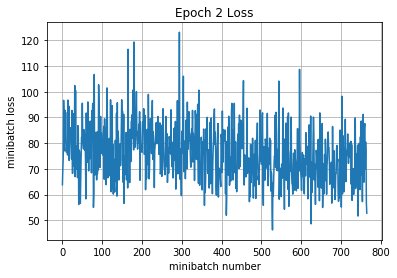

Iteration 1600: with minibatch training loss = 0.952 and accuracy of 0.66
Iteration 1700: with minibatch training loss = 1 and accuracy of 0.66
Iteration 1800: with minibatch training loss = 1.16 and accuracy of 0.64
Iteration 1900: with minibatch training loss = 1.04 and accuracy of 0.67
Iteration 2000: with minibatch training loss = 0.824 and accuracy of 0.77
Iteration 2100: with minibatch training loss = 1.24 and accuracy of 0.56
Iteration 2200: with minibatch training loss = 1.19 and accuracy of 0.59
Epoch 3, Overall loss = 1.03 and accuracy of 0.639


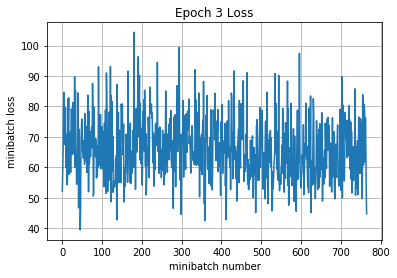

Iteration 2300: with minibatch training loss = 0.929 and accuracy of 0.64
Iteration 2400: with minibatch training loss = 1.01 and accuracy of 0.62
Iteration 2500: with minibatch training loss = 0.95 and accuracy of 0.67
Iteration 2600: with minibatch training loss = 1.04 and accuracy of 0.59
Iteration 2700: with minibatch training loss = 1.25 and accuracy of 0.59
Iteration 2800: with minibatch training loss = 1.18 and accuracy of 0.61
Iteration 2900: with minibatch training loss = 0.78 and accuracy of 0.75
Iteration 3000: with minibatch training loss = 0.932 and accuracy of 0.67
Epoch 4, Overall loss = 0.952 and accuracy of 0.67


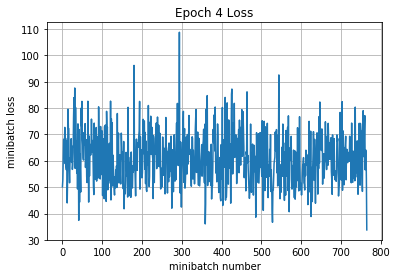

Iteration 3100: with minibatch training loss = 0.833 and accuracy of 0.67
Iteration 3200: with minibatch training loss = 0.908 and accuracy of 0.59
Iteration 3300: with minibatch training loss = 0.946 and accuracy of 0.61
Iteration 3400: with minibatch training loss = 1.01 and accuracy of 0.67
Iteration 3500: with minibatch training loss = 0.759 and accuracy of 0.7
Iteration 3600: with minibatch training loss = 0.898 and accuracy of 0.66
Iteration 3700: with minibatch training loss = 0.667 and accuracy of 0.73
Iteration 3800: with minibatch training loss = 1.06 and accuracy of 0.64
Epoch 5, Overall loss = 0.89 and accuracy of 0.689


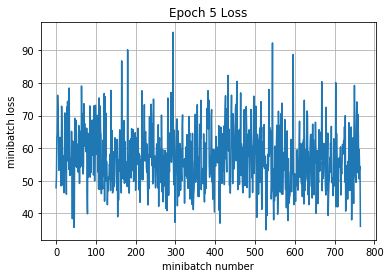

Iteration 3900: with minibatch training loss = 0.986 and accuracy of 0.61
Iteration 4000: with minibatch training loss = 0.818 and accuracy of 0.72
Iteration 4100: with minibatch training loss = 0.849 and accuracy of 0.7
Iteration 4200: with minibatch training loss = 0.85 and accuracy of 0.73
Iteration 4300: with minibatch training loss = 0.714 and accuracy of 0.73
Iteration 4400: with minibatch training loss = 0.538 and accuracy of 0.84
Iteration 4500: with minibatch training loss = 0.913 and accuracy of 0.7
Epoch 6, Overall loss = 0.845 and accuracy of 0.705


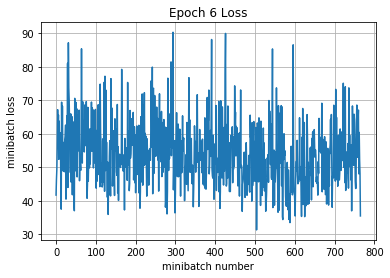

Iteration 4600: with minibatch training loss = 0.859 and accuracy of 0.72
Iteration 4700: with minibatch training loss = 0.972 and accuracy of 0.69
Iteration 4800: with minibatch training loss = 0.821 and accuracy of 0.77
Iteration 4900: with minibatch training loss = 0.892 and accuracy of 0.69
Iteration 5000: with minibatch training loss = 0.954 and accuracy of 0.61
Iteration 5100: with minibatch training loss = 0.481 and accuracy of 0.81
Iteration 5200: with minibatch training loss = 0.727 and accuracy of 0.77
Iteration 5300: with minibatch training loss = 0.733 and accuracy of 0.72
Epoch 7, Overall loss = 0.815 and accuracy of 0.718


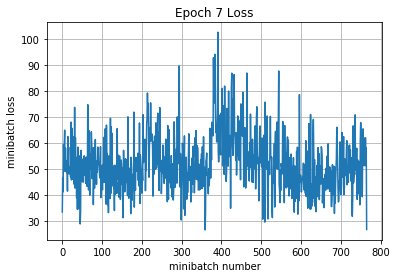

Iteration 5400: with minibatch training loss = 0.631 and accuracy of 0.78
Iteration 5500: with minibatch training loss = 1.03 and accuracy of 0.64
Iteration 5600: with minibatch training loss = 0.895 and accuracy of 0.72
Iteration 5700: with minibatch training loss = 0.869 and accuracy of 0.69
Iteration 5800: with minibatch training loss = 0.58 and accuracy of 0.83
Iteration 5900: with minibatch training loss = 0.859 and accuracy of 0.67
Iteration 6000: with minibatch training loss = 0.655 and accuracy of 0.7
Iteration 6100: with minibatch training loss = 0.82 and accuracy of 0.73
Epoch 8, Overall loss = 0.8 and accuracy of 0.719


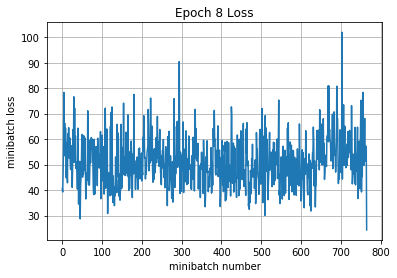

Iteration 6200: with minibatch training loss = 1 and accuracy of 0.61
Iteration 6300: with minibatch training loss = 0.51 and accuracy of 0.78
Iteration 6400: with minibatch training loss = 0.672 and accuracy of 0.77
Iteration 6500: with minibatch training loss = 0.736 and accuracy of 0.72
Iteration 6600: with minibatch training loss = 0.751 and accuracy of 0.75
Iteration 6700: with minibatch training loss = 0.708 and accuracy of 0.78
Iteration 6800: with minibatch training loss = 0.695 and accuracy of 0.69
Epoch 9, Overall loss = 0.779 and accuracy of 0.726


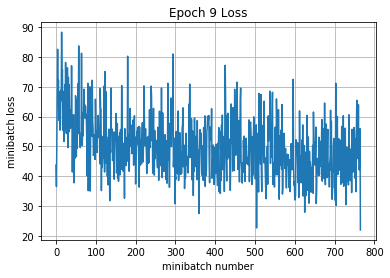

Iteration 6900: with minibatch training loss = 0.811 and accuracy of 0.67
Iteration 7000: with minibatch training loss = 1.1 and accuracy of 0.72
Iteration 7100: with minibatch training loss = 0.854 and accuracy of 0.75
Iteration 7200: with minibatch training loss = 0.727 and accuracy of 0.72
Iteration 7300: with minibatch training loss = 0.502 and accuracy of 0.81
Iteration 7400: with minibatch training loss = 0.836 and accuracy of 0.67
Iteration 7500: with minibatch training loss = 0.823 and accuracy of 0.75
Iteration 7600: with minibatch training loss = 0.738 and accuracy of 0.72
Epoch 10, Overall loss = 0.697 and accuracy of 0.759


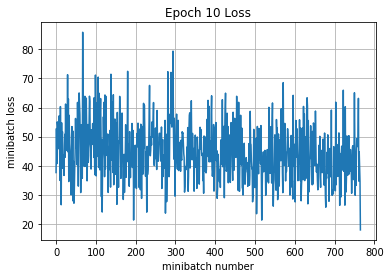

Validation
Epoch 1, Overall loss = 1.33 and accuracy of 0.641


(1.3259159173965454, 0.64100000000000001)

In [33]:
# model_2
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model_2(X,y,is_training)
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.AdamOptimizer()


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
    
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 3.24 and accuracy of 0.14
Iteration 100: with minibatch training loss = 1.66 and accuracy of 0.39
Iteration 200: with minibatch training loss = 1.32 and accuracy of 0.56
Iteration 300: with minibatch training loss = 1.28 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.2 and accuracy of 0.53
Iteration 500: with minibatch training loss = 1.03 and accuracy of 0.7
Iteration 600: with minibatch training loss = 0.937 and accuracy of 0.62
Iteration 700: with minibatch training loss = 1.13 and accuracy of 0.59
Epoch 1, Overall loss = 1.38 and accuracy of 0.548


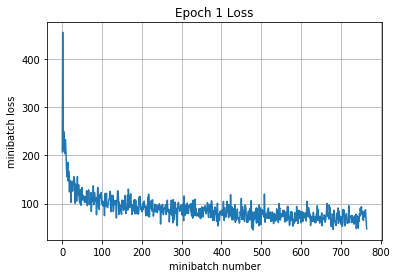

Iteration 800: with minibatch training loss = 0.891 and accuracy of 0.66
Iteration 900: with minibatch training loss = 1.15 and accuracy of 0.64
Iteration 1000: with minibatch training loss = 0.83 and accuracy of 0.72
Iteration 1100: with minibatch training loss = 0.862 and accuracy of 0.77
Iteration 1200: with minibatch training loss = 0.977 and accuracy of 0.62
Iteration 1300: with minibatch training loss = 0.805 and accuracy of 0.7
Iteration 1400: with minibatch training loss = 0.731 and accuracy of 0.75
Iteration 1500: with minibatch training loss = 0.817 and accuracy of 0.67
Epoch 2, Overall loss = 0.914 and accuracy of 0.685


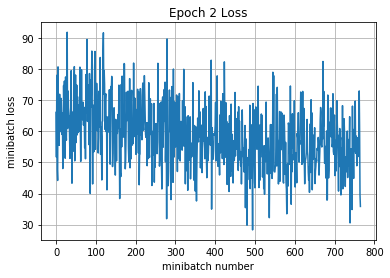

Iteration 1600: with minibatch training loss = 0.799 and accuracy of 0.78
Iteration 1700: with minibatch training loss = 0.698 and accuracy of 0.8
Iteration 1800: with minibatch training loss = 1.13 and accuracy of 0.66
Iteration 1900: with minibatch training loss = 0.56 and accuracy of 0.84
Iteration 2000: with minibatch training loss = 0.683 and accuracy of 0.72
Iteration 2100: with minibatch training loss = 0.839 and accuracy of 0.7
Iteration 2200: with minibatch training loss = 0.787 and accuracy of 0.81
Epoch 3, Overall loss = 0.694 and accuracy of 0.762


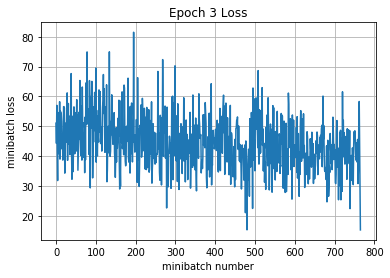

Iteration 2300: with minibatch training loss = 0.607 and accuracy of 0.77
Iteration 2400: with minibatch training loss = 0.824 and accuracy of 0.7
Iteration 2500: with minibatch training loss = 0.677 and accuracy of 0.75
Iteration 2600: with minibatch training loss = 0.555 and accuracy of 0.77
Iteration 2700: with minibatch training loss = 0.449 and accuracy of 0.84
Iteration 2800: with minibatch training loss = 0.509 and accuracy of 0.84
Iteration 2900: with minibatch training loss = 0.401 and accuracy of 0.84
Iteration 3000: with minibatch training loss = 0.286 and accuracy of 0.92
Epoch 4, Overall loss = 0.483 and accuracy of 0.833


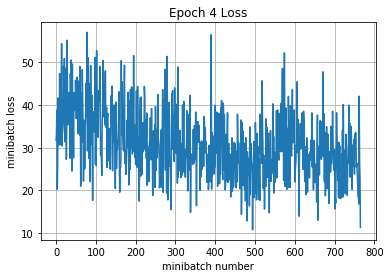

Iteration 3100: with minibatch training loss = 0.471 and accuracy of 0.83
Iteration 3200: with minibatch training loss = 0.407 and accuracy of 0.84
Iteration 3300: with minibatch training loss = 0.337 and accuracy of 0.86
Iteration 3400: with minibatch training loss = 0.311 and accuracy of 0.89
Iteration 3500: with minibatch training loss = 0.29 and accuracy of 0.88
Iteration 3600: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 3700: with minibatch training loss = 0.26 and accuracy of 0.92
Iteration 3800: with minibatch training loss = 0.315 and accuracy of 0.88
Epoch 5, Overall loss = 0.3 and accuracy of 0.897


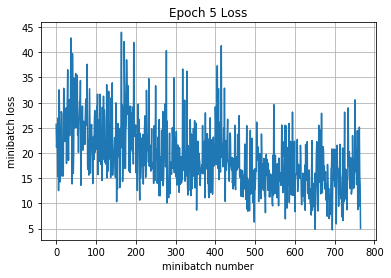

Iteration 3900: with minibatch training loss = 0.248 and accuracy of 0.92
Iteration 4000: with minibatch training loss = 0.18 and accuracy of 0.91
Iteration 4100: with minibatch training loss = 0.152 and accuracy of 0.95
Iteration 4200: with minibatch training loss = 0.332 and accuracy of 0.88
Iteration 4300: with minibatch training loss = 0.168 and accuracy of 0.94
Iteration 4400: with minibatch training loss = 0.0786 and accuracy of 0.97
Iteration 4500: with minibatch training loss = 0.278 and accuracy of 0.89
Epoch 6, Overall loss = 0.17 and accuracy of 0.943


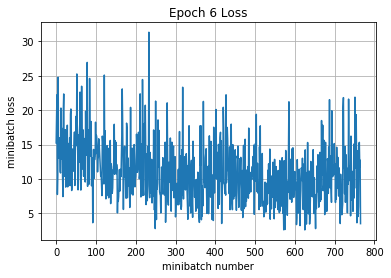

Iteration 4600: with minibatch training loss = 0.138 and accuracy of 0.97
Iteration 4700: with minibatch training loss = 0.136 and accuracy of 0.94
Iteration 4800: with minibatch training loss = 0.168 and accuracy of 0.95
Iteration 4900: with minibatch training loss = 0.158 and accuracy of 0.94
Iteration 5000: with minibatch training loss = 0.0898 and accuracy of 0.97
Iteration 5100: with minibatch training loss = 0.165 and accuracy of 0.92
Iteration 5200: with minibatch training loss = 0.204 and accuracy of 0.95
Iteration 5300: with minibatch training loss = 0.0811 and accuracy of 0.98
Epoch 7, Overall loss = 0.143 and accuracy of 0.951


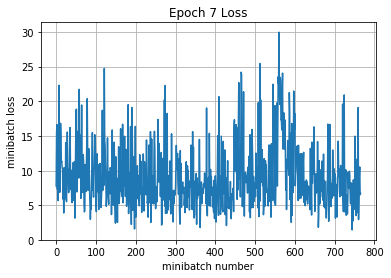

Iteration 5400: with minibatch training loss = 0.195 and accuracy of 0.92
Iteration 5500: with minibatch training loss = 0.175 and accuracy of 0.94
Iteration 5600: with minibatch training loss = 0.151 and accuracy of 0.97
Iteration 5700: with minibatch training loss = 0.131 and accuracy of 0.97
Iteration 5800: with minibatch training loss = 0.296 and accuracy of 0.94
Iteration 5900: with minibatch training loss = 0.0375 and accuracy of 0.98
Iteration 6000: with minibatch training loss = 0.148 and accuracy of 0.95
Iteration 6100: with minibatch training loss = 0.0335 and accuracy of 1
Epoch 8, Overall loss = 0.146 and accuracy of 0.95


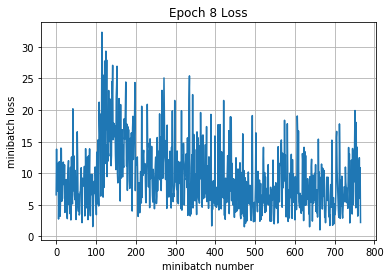

Iteration 6200: with minibatch training loss = 0.0613 and accuracy of 0.97
Iteration 6300: with minibatch training loss = 0.177 and accuracy of 0.92
Iteration 6400: with minibatch training loss = 0.0441 and accuracy of 1
Iteration 6500: with minibatch training loss = 0.178 and accuracy of 0.94
Iteration 6600: with minibatch training loss = 0.143 and accuracy of 0.95
Iteration 6700: with minibatch training loss = 0.0289 and accuracy of 0.98
Iteration 6800: with minibatch training loss = 0.0639 and accuracy of 0.98
Epoch 9, Overall loss = 0.0784 and accuracy of 0.974


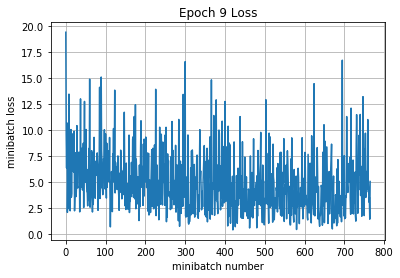

Iteration 6900: with minibatch training loss = 0.0567 and accuracy of 0.97
Iteration 7000: with minibatch training loss = 0.104 and accuracy of 0.97
Iteration 7100: with minibatch training loss = 0.0776 and accuracy of 0.95
Iteration 7200: with minibatch training loss = 0.0715 and accuracy of 0.98
Iteration 7300: with minibatch training loss = 0.125 and accuracy of 0.94
Iteration 7400: with minibatch training loss = 0.057 and accuracy of 0.98
Iteration 7500: with minibatch training loss = 0.0449 and accuracy of 0.98
Iteration 7600: with minibatch training loss = 0.145 and accuracy of 0.95
Epoch 10, Overall loss = 0.0751 and accuracy of 0.975


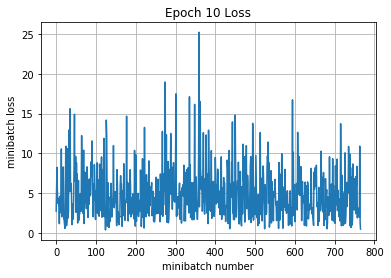

Validation
Epoch 1, Overall loss = 1.48 and accuracy of 0.712


(1.4787032146453858, 0.71199999999999997)

In [50]:
# model_3
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model_3(X,y,is_training)
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.AdamOptimizer()


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
    
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 2.59 and accuracy of 0.17
Iteration 100: with minibatch training loss = 1.63 and accuracy of 0.41
Iteration 200: with minibatch training loss = 1.47 and accuracy of 0.45
Iteration 300: with minibatch training loss = 1.31 and accuracy of 0.5
Iteration 400: with minibatch training loss = 1.23 and accuracy of 0.53
Iteration 500: with minibatch training loss = 1.36 and accuracy of 0.48
Iteration 600: with minibatch training loss = 1.23 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.28 and accuracy of 0.61
Epoch 1, Overall loss = 1.47 and accuracy of 0.481


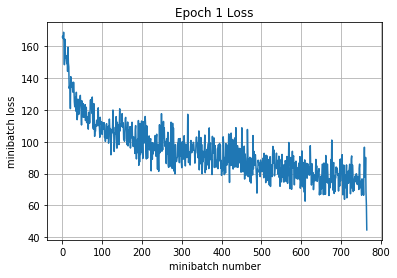

Iteration 800: with minibatch training loss = 1.03 and accuracy of 0.67
Iteration 900: with minibatch training loss = 0.935 and accuracy of 0.77
Iteration 1000: with minibatch training loss = 1.09 and accuracy of 0.62
Iteration 1100: with minibatch training loss = 1.08 and accuracy of 0.56
Iteration 1200: with minibatch training loss = 0.833 and accuracy of 0.69
Iteration 1300: with minibatch training loss = 1.08 and accuracy of 0.66
Iteration 1400: with minibatch training loss = 0.841 and accuracy of 0.72
Iteration 1500: with minibatch training loss = 1.05 and accuracy of 0.62
Epoch 2, Overall loss = 1.03 and accuracy of 0.652


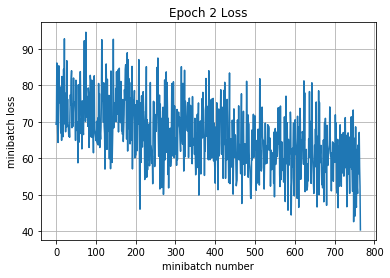

Iteration 1600: with minibatch training loss = 0.812 and accuracy of 0.73
Iteration 1700: with minibatch training loss = 0.969 and accuracy of 0.64
Iteration 1800: with minibatch training loss = 0.906 and accuracy of 0.73
Iteration 1900: with minibatch training loss = 0.644 and accuracy of 0.81
Iteration 2000: with minibatch training loss = 0.733 and accuracy of 0.69
Iteration 2100: with minibatch training loss = 0.733 and accuracy of 0.72
Iteration 2200: with minibatch training loss = 0.762 and accuracy of 0.77
Epoch 3, Overall loss = 0.825 and accuracy of 0.727


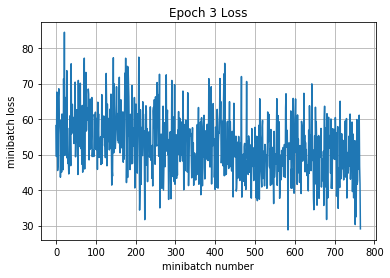

Iteration 2300: with minibatch training loss = 0.796 and accuracy of 0.72
Iteration 2400: with minibatch training loss = 0.673 and accuracy of 0.75
Iteration 2500: with minibatch training loss = 0.747 and accuracy of 0.73
Iteration 2600: with minibatch training loss = 0.723 and accuracy of 0.78
Iteration 2700: with minibatch training loss = 0.674 and accuracy of 0.78
Iteration 2800: with minibatch training loss = 0.578 and accuracy of 0.78
Iteration 2900: with minibatch training loss = 0.836 and accuracy of 0.72
Iteration 3000: with minibatch training loss = 0.811 and accuracy of 0.73
Epoch 4, Overall loss = 0.687 and accuracy of 0.775


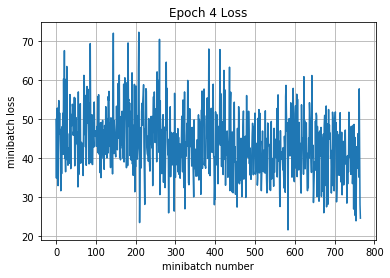

Iteration 3100: with minibatch training loss = 0.638 and accuracy of 0.8
Iteration 3200: with minibatch training loss = 0.633 and accuracy of 0.77
Iteration 3300: with minibatch training loss = 0.542 and accuracy of 0.88
Iteration 3400: with minibatch training loss = 0.737 and accuracy of 0.78
Iteration 3500: with minibatch training loss = 0.786 and accuracy of 0.72
Iteration 3600: with minibatch training loss = 0.471 and accuracy of 0.83
Iteration 3700: with minibatch training loss = 0.637 and accuracy of 0.8
Iteration 3800: with minibatch training loss = 0.494 and accuracy of 0.88
Epoch 5, Overall loss = 0.582 and accuracy of 0.812


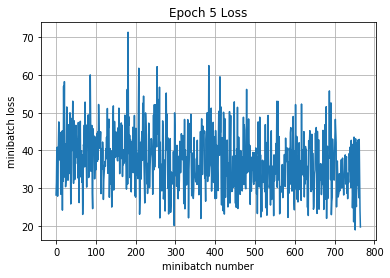

Iteration 3900: with minibatch training loss = 0.569 and accuracy of 0.83
Iteration 4000: with minibatch training loss = 0.665 and accuracy of 0.8
Iteration 4100: with minibatch training loss = 0.381 and accuracy of 0.84
Iteration 4200: with minibatch training loss = 0.611 and accuracy of 0.84
Iteration 4300: with minibatch training loss = 0.478 and accuracy of 0.91
Iteration 4400: with minibatch training loss = 0.442 and accuracy of 0.83
Iteration 4500: with minibatch training loss = 0.301 and accuracy of 0.91
Epoch 6, Overall loss = 0.501 and accuracy of 0.838


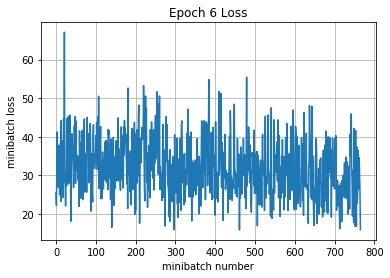

Iteration 4600: with minibatch training loss = 0.351 and accuracy of 0.89
Iteration 4700: with minibatch training loss = 0.457 and accuracy of 0.84
Iteration 4800: with minibatch training loss = 0.359 and accuracy of 0.86
Iteration 4900: with minibatch training loss = 0.479 and accuracy of 0.89
Iteration 5000: with minibatch training loss = 0.463 and accuracy of 0.86
Iteration 5100: with minibatch training loss = 0.311 and accuracy of 0.92
Iteration 5200: with minibatch training loss = 0.279 and accuracy of 0.94
Iteration 5300: with minibatch training loss = 0.532 and accuracy of 0.86
Epoch 7, Overall loss = 0.43 and accuracy of 0.863


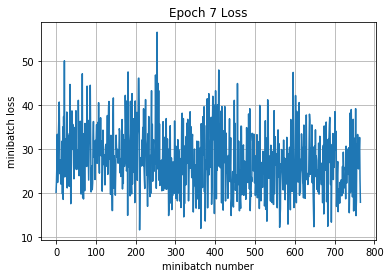

Iteration 5400: with minibatch training loss = 0.412 and accuracy of 0.89
Iteration 5500: with minibatch training loss = 0.44 and accuracy of 0.86
Iteration 5600: with minibatch training loss = 0.257 and accuracy of 0.88
Iteration 5700: with minibatch training loss = 0.34 and accuracy of 0.91
Iteration 5800: with minibatch training loss = 0.422 and accuracy of 0.88
Iteration 5900: with minibatch training loss = 0.357 and accuracy of 0.86
Iteration 6000: with minibatch training loss = 0.509 and accuracy of 0.88
Iteration 6100: with minibatch training loss = 0.225 and accuracy of 0.95
Epoch 8, Overall loss = 0.368 and accuracy of 0.883


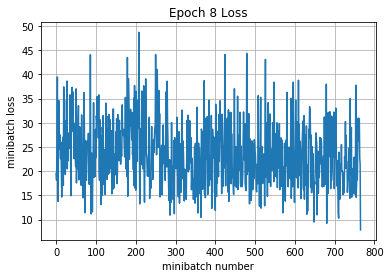

Iteration 6200: with minibatch training loss = 0.191 and accuracy of 0.94
Iteration 6300: with minibatch training loss = 0.343 and accuracy of 0.86
Iteration 6400: with minibatch training loss = 0.247 and accuracy of 0.94
Iteration 6500: with minibatch training loss = 0.337 and accuracy of 0.92
Iteration 6600: with minibatch training loss = 0.239 and accuracy of 0.92
Iteration 6700: with minibatch training loss = 0.358 and accuracy of 0.91
Iteration 6800: with minibatch training loss = 0.197 and accuracy of 0.94
Epoch 9, Overall loss = 0.314 and accuracy of 0.9


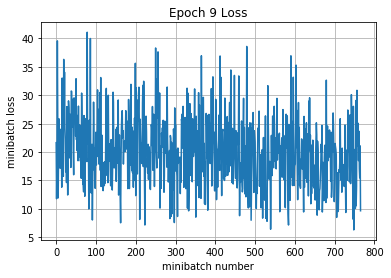

Iteration 6900: with minibatch training loss = 0.236 and accuracy of 0.95
Iteration 7000: with minibatch training loss = 0.346 and accuracy of 0.88
Iteration 7100: with minibatch training loss = 0.317 and accuracy of 0.91
Iteration 7200: with minibatch training loss = 0.209 and accuracy of 0.97
Iteration 7300: with minibatch training loss = 0.378 and accuracy of 0.88
Iteration 7400: with minibatch training loss = 0.231 and accuracy of 0.94
Iteration 7500: with minibatch training loss = 0.315 and accuracy of 0.89
Iteration 7600: with minibatch training loss = 0.18 and accuracy of 0.92
Epoch 10, Overall loss = 0.275 and accuracy of 0.914


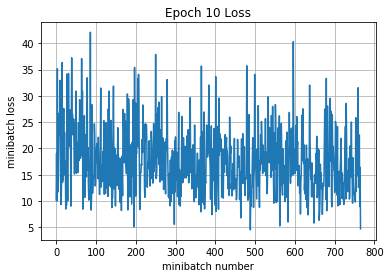

Validation
Epoch 1, Overall loss = 0.794 and accuracy of 0.762


(0.79351590156555174, 0.76200000000000001)

In [64]:
# Resnet model
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = resnet(X,y,is_training)
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.AdamOptimizer()


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
    
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 2.51 and accuracy of 0.17
Iteration 100: with minibatch training loss = 1.6 and accuracy of 0.38
Iteration 200: with minibatch training loss = 1.34 and accuracy of 0.61
Iteration 300: with minibatch training loss = 1.37 and accuracy of 0.61
Iteration 400: with minibatch training loss = 1.36 and accuracy of 0.47
Iteration 500: with minibatch training loss = 1.06 and accuracy of 0.69
Iteration 600: with minibatch training loss = 0.975 and accuracy of 0.73
Iteration 700: with minibatch training loss = 1.26 and accuracy of 0.5
Epoch 1, Overall loss = 1.42 and accuracy of 0.502


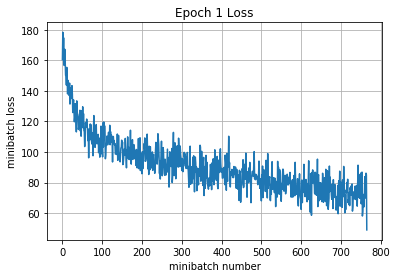

Iteration 800: with minibatch training loss = 1.12 and accuracy of 0.69
Iteration 900: with minibatch training loss = 0.94 and accuracy of 0.69
Iteration 1000: with minibatch training loss = 0.932 and accuracy of 0.73
Iteration 1100: with minibatch training loss = 1.01 and accuracy of 0.66
Iteration 1200: with minibatch training loss = 0.87 and accuracy of 0.69
Iteration 1300: with minibatch training loss = 0.887 and accuracy of 0.66
Iteration 1400: with minibatch training loss = 0.918 and accuracy of 0.69
Iteration 1500: with minibatch training loss = 0.791 and accuracy of 0.77
Epoch 2, Overall loss = 0.955 and accuracy of 0.679


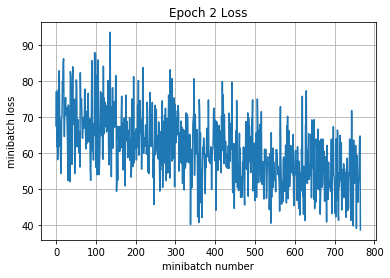

Iteration 1600: with minibatch training loss = 0.731 and accuracy of 0.77
Iteration 1700: with minibatch training loss = 0.703 and accuracy of 0.75
Iteration 1800: with minibatch training loss = 0.459 and accuracy of 0.84
Iteration 1900: with minibatch training loss = 0.742 and accuracy of 0.77
Iteration 2000: with minibatch training loss = 0.397 and accuracy of 0.89
Iteration 2100: with minibatch training loss = 0.663 and accuracy of 0.81
Iteration 2200: with minibatch training loss = 0.697 and accuracy of 0.77
Epoch 3, Overall loss = 0.72 and accuracy of 0.764


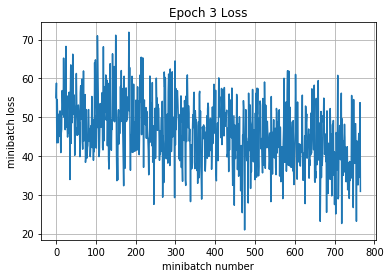

Iteration 2300: with minibatch training loss = 0.602 and accuracy of 0.83
Iteration 2400: with minibatch training loss = 0.624 and accuracy of 0.8
Iteration 2500: with minibatch training loss = 0.641 and accuracy of 0.73
Iteration 2600: with minibatch training loss = 0.411 and accuracy of 0.89
Iteration 2700: with minibatch training loss = 0.43 and accuracy of 0.91
Iteration 2800: with minibatch training loss = 0.439 and accuracy of 0.88
Iteration 2900: with minibatch training loss = 0.76 and accuracy of 0.78
Iteration 3000: with minibatch training loss = 0.635 and accuracy of 0.78
Epoch 4, Overall loss = 0.573 and accuracy of 0.814


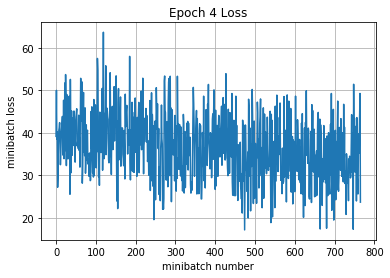

Iteration 3100: with minibatch training loss = 0.68 and accuracy of 0.78
Iteration 3200: with minibatch training loss = 0.718 and accuracy of 0.75
Iteration 3300: with minibatch training loss = 0.63 and accuracy of 0.75
Iteration 3400: with minibatch training loss = 0.539 and accuracy of 0.84
Iteration 3500: with minibatch training loss = 0.387 and accuracy of 0.86
Iteration 3600: with minibatch training loss = 0.253 and accuracy of 0.95
Iteration 3700: with minibatch training loss = 0.232 and accuracy of 0.92
Iteration 3800: with minibatch training loss = 0.483 and accuracy of 0.89
Epoch 5, Overall loss = 0.463 and accuracy of 0.852


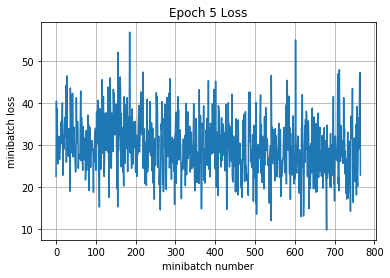

Iteration 3900: with minibatch training loss = 0.382 and accuracy of 0.86
Iteration 4000: with minibatch training loss = 0.201 and accuracy of 0.97
Iteration 4100: with minibatch training loss = 0.338 and accuracy of 0.88
Iteration 4200: with minibatch training loss = 0.371 and accuracy of 0.91
Iteration 4300: with minibatch training loss = 0.434 and accuracy of 0.88
Iteration 4400: with minibatch training loss = 0.297 and accuracy of 0.89
Iteration 4500: with minibatch training loss = 0.324 and accuracy of 0.88
Epoch 6, Overall loss = 0.384 and accuracy of 0.877


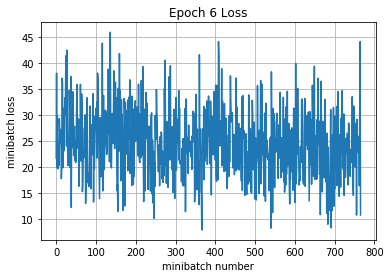

Iteration 4600: with minibatch training loss = 0.199 and accuracy of 0.94
Iteration 4700: with minibatch training loss = 0.413 and accuracy of 0.91
Iteration 4800: with minibatch training loss = 0.29 and accuracy of 0.92
Iteration 4900: with minibatch training loss = 0.222 and accuracy of 0.95
Iteration 5000: with minibatch training loss = 0.381 and accuracy of 0.88
Iteration 5100: with minibatch training loss = 0.406 and accuracy of 0.89
Iteration 5200: with minibatch training loss = 0.324 and accuracy of 0.84
Iteration 5300: with minibatch training loss = 0.353 and accuracy of 0.86
Epoch 7, Overall loss = 0.326 and accuracy of 0.897


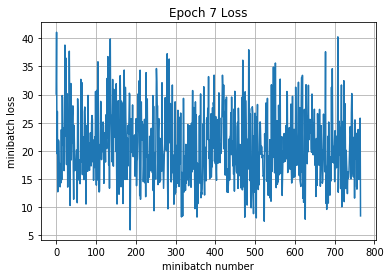

Iteration 5400: with minibatch training loss = 0.25 and accuracy of 0.91
Iteration 5500: with minibatch training loss = 0.153 and accuracy of 0.95
Iteration 5600: with minibatch training loss = 0.342 and accuracy of 0.89
Iteration 5700: with minibatch training loss = 0.212 and accuracy of 0.97
Iteration 5800: with minibatch training loss = 0.205 and accuracy of 0.94
Iteration 5900: with minibatch training loss = 0.301 and accuracy of 0.94
Iteration 6000: with minibatch training loss = 0.472 and accuracy of 0.88
Iteration 6100: with minibatch training loss = 0.303 and accuracy of 0.89
Epoch 8, Overall loss = 0.266 and accuracy of 0.917


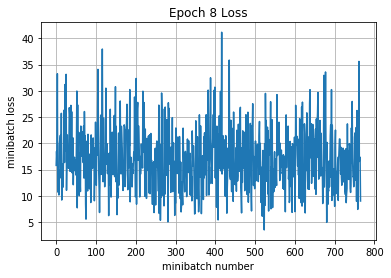

Iteration 6200: with minibatch training loss = 0.267 and accuracy of 0.88
Iteration 6300: with minibatch training loss = 0.203 and accuracy of 0.94
Iteration 6400: with minibatch training loss = 0.189 and accuracy of 0.94
Iteration 6500: with minibatch training loss = 0.2 and accuracy of 0.95
Iteration 6600: with minibatch training loss = 0.229 and accuracy of 0.92
Iteration 6700: with minibatch training loss = 0.126 and accuracy of 0.97
Iteration 6800: with minibatch training loss = 0.141 and accuracy of 0.98
Epoch 9, Overall loss = 0.233 and accuracy of 0.927


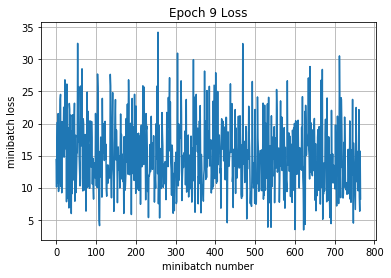

Iteration 6900: with minibatch training loss = 0.171 and accuracy of 0.94
Iteration 7000: with minibatch training loss = 0.479 and accuracy of 0.89
Iteration 7100: with minibatch training loss = 0.115 and accuracy of 0.97
Iteration 7200: with minibatch training loss = 0.253 and accuracy of 0.89
Iteration 7300: with minibatch training loss = 0.145 and accuracy of 0.97
Iteration 7400: with minibatch training loss = 0.246 and accuracy of 0.91
Iteration 7500: with minibatch training loss = 0.24 and accuracy of 0.95
Iteration 7600: with minibatch training loss = 0.143 and accuracy of 0.97
Epoch 10, Overall loss = 0.208 and accuracy of 0.935


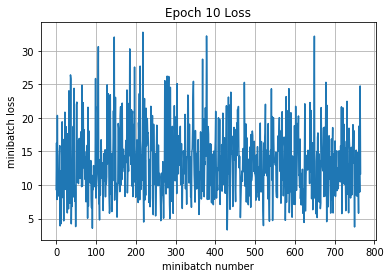

Validation
Epoch 1, Overall loss = 0.78 and accuracy of 0.776


(0.78009116888046259, 0.77600000000000002)

In [72]:
# Highwaynet model
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = Highwaynet(X,y,is_training)
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.AdamOptimizer()


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
    
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 2.64 and accuracy of 0.11
Iteration 100: with minibatch training loss = 1.69 and accuracy of 0.34
Iteration 200: with minibatch training loss = 1.78 and accuracy of 0.31
Iteration 300: with minibatch training loss = 1.61 and accuracy of 0.53
Iteration 400: with minibatch training loss = 1.5 and accuracy of 0.44
Iteration 500: with minibatch training loss = 1.42 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.27 and accuracy of 0.55
Iteration 700: with minibatch training loss = 1.28 and accuracy of 0.55
Epoch 1, Overall loss = 1.6 and accuracy of 0.434


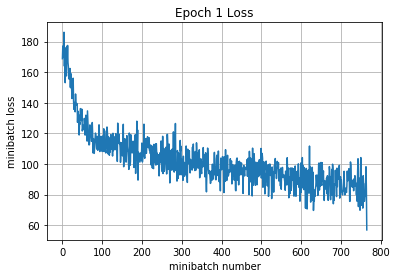

Iteration 800: with minibatch training loss = 1.35 and accuracy of 0.53
Iteration 900: with minibatch training loss = 1.34 and accuracy of 0.52
Iteration 1000: with minibatch training loss = 1.25 and accuracy of 0.62
Iteration 1100: with minibatch training loss = 1.3 and accuracy of 0.59
Iteration 1200: with minibatch training loss = 1.17 and accuracy of 0.56
Iteration 1300: with minibatch training loss = 1.11 and accuracy of 0.55
Iteration 1400: with minibatch training loss = 0.916 and accuracy of 0.69
Iteration 1500: with minibatch training loss = 1.08 and accuracy of 0.69
Epoch 2, Overall loss = 1.16 and accuracy of 0.599


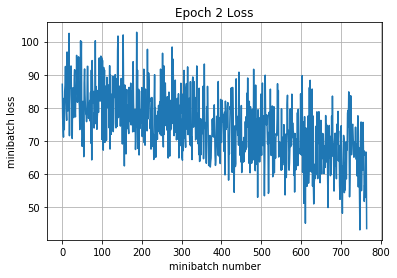

Iteration 1600: with minibatch training loss = 1.16 and accuracy of 0.56
Iteration 1700: with minibatch training loss = 1.09 and accuracy of 0.67
Iteration 1800: with minibatch training loss = 1.03 and accuracy of 0.62
Iteration 1900: with minibatch training loss = 0.809 and accuracy of 0.75
Iteration 2000: with minibatch training loss = 0.875 and accuracy of 0.73
Iteration 2100: with minibatch training loss = 0.917 and accuracy of 0.64
Iteration 2200: with minibatch training loss = 0.715 and accuracy of 0.7
Epoch 3, Overall loss = 0.922 and accuracy of 0.689


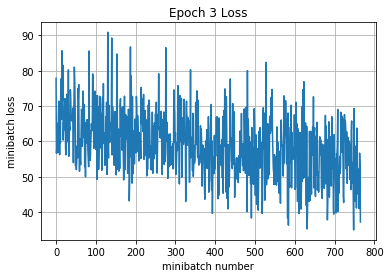

Iteration 2300: with minibatch training loss = 0.681 and accuracy of 0.78
Iteration 2400: with minibatch training loss = 0.825 and accuracy of 0.75
Iteration 2500: with minibatch training loss = 0.917 and accuracy of 0.7
Iteration 2600: with minibatch training loss = 0.641 and accuracy of 0.81
Iteration 2700: with minibatch training loss = 0.912 and accuracy of 0.69
Iteration 2800: with minibatch training loss = 0.88 and accuracy of 0.75
Iteration 2900: with minibatch training loss = 0.553 and accuracy of 0.84
Iteration 3000: with minibatch training loss = 0.737 and accuracy of 0.77
Epoch 4, Overall loss = 0.764 and accuracy of 0.747


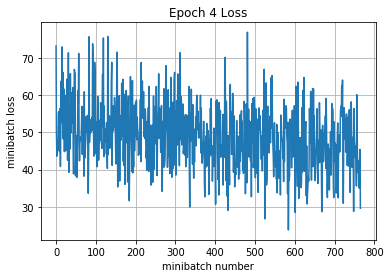

Iteration 3100: with minibatch training loss = 0.921 and accuracy of 0.7
Iteration 3200: with minibatch training loss = 0.708 and accuracy of 0.78
Iteration 3300: with minibatch training loss = 0.725 and accuracy of 0.75
Iteration 3400: with minibatch training loss = 0.435 and accuracy of 0.89
Iteration 3500: with minibatch training loss = 0.49 and accuracy of 0.81
Iteration 3600: with minibatch training loss = 0.618 and accuracy of 0.78
Iteration 3700: with minibatch training loss = 0.635 and accuracy of 0.78
Iteration 3800: with minibatch training loss = 0.574 and accuracy of 0.8
Epoch 5, Overall loss = 0.658 and accuracy of 0.784


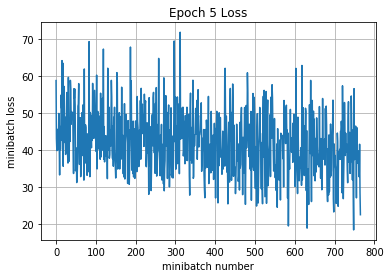

Iteration 3900: with minibatch training loss = 0.427 and accuracy of 0.83
Iteration 4000: with minibatch training loss = 0.603 and accuracy of 0.77
Iteration 4100: with minibatch training loss = 0.36 and accuracy of 0.92
Iteration 4200: with minibatch training loss = 0.529 and accuracy of 0.83
Iteration 4300: with minibatch training loss = 0.716 and accuracy of 0.73
Iteration 4400: with minibatch training loss = 0.515 and accuracy of 0.83
Iteration 4500: with minibatch training loss = 0.671 and accuracy of 0.78
Epoch 6, Overall loss = 0.574 and accuracy of 0.812


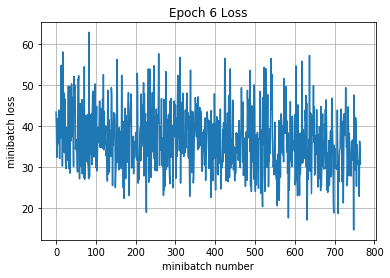

Iteration 4600: with minibatch training loss = 0.541 and accuracy of 0.83
Iteration 4700: with minibatch training loss = 0.4 and accuracy of 0.91
Iteration 4800: with minibatch training loss = 0.621 and accuracy of 0.8
Iteration 4900: with minibatch training loss = 0.409 and accuracy of 0.89
Iteration 5000: with minibatch training loss = 0.501 and accuracy of 0.86
Iteration 5100: with minibatch training loss = 0.39 and accuracy of 0.86
Iteration 5200: with minibatch training loss = 0.467 and accuracy of 0.83
Iteration 5300: with minibatch training loss = 0.31 and accuracy of 0.94
Epoch 7, Overall loss = 0.499 and accuracy of 0.838


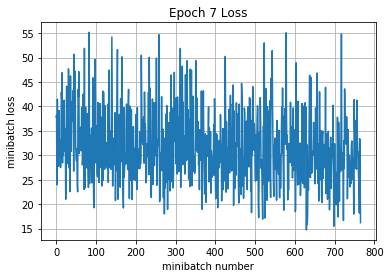

Iteration 5400: with minibatch training loss = 0.423 and accuracy of 0.86
Iteration 5500: with minibatch training loss = 0.416 and accuracy of 0.89
Iteration 5600: with minibatch training loss = 0.328 and accuracy of 0.89
Iteration 5700: with minibatch training loss = 0.564 and accuracy of 0.83
Iteration 5800: with minibatch training loss = 0.455 and accuracy of 0.84
Iteration 5900: with minibatch training loss = 0.365 and accuracy of 0.86
Iteration 6000: with minibatch training loss = 0.377 and accuracy of 0.89
Iteration 6100: with minibatch training loss = 0.382 and accuracy of 0.86
Epoch 8, Overall loss = 0.433 and accuracy of 0.86


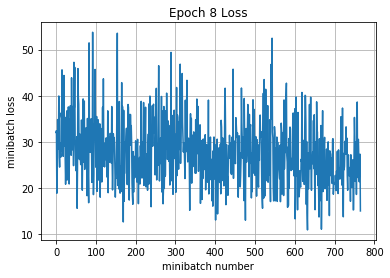

Iteration 6200: with minibatch training loss = 0.267 and accuracy of 0.92
Iteration 6300: with minibatch training loss = 0.365 and accuracy of 0.91
Iteration 6400: with minibatch training loss = 0.22 and accuracy of 0.94
Iteration 6500: with minibatch training loss = 0.293 and accuracy of 0.92
Iteration 6600: with minibatch training loss = 0.268 and accuracy of 0.89
Iteration 6700: with minibatch training loss = 0.304 and accuracy of 0.89
Iteration 6800: with minibatch training loss = 0.392 and accuracy of 0.89
Epoch 9, Overall loss = 0.383 and accuracy of 0.876


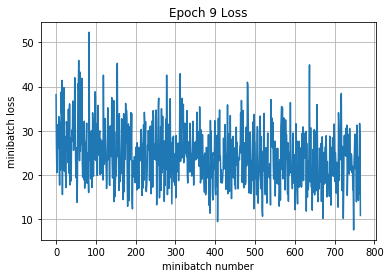

Iteration 6900: with minibatch training loss = 0.36 and accuracy of 0.89
Iteration 7000: with minibatch training loss = 0.299 and accuracy of 0.92
Iteration 7100: with minibatch training loss = 0.412 and accuracy of 0.89
Iteration 7200: with minibatch training loss = 0.399 and accuracy of 0.89
Iteration 7300: with minibatch training loss = 0.181 and accuracy of 0.97
Iteration 7400: with minibatch training loss = 0.475 and accuracy of 0.86
Iteration 7500: with minibatch training loss = 0.281 and accuracy of 0.94
Iteration 7600: with minibatch training loss = 0.307 and accuracy of 0.88
Epoch 10, Overall loss = 0.334 and accuracy of 0.892


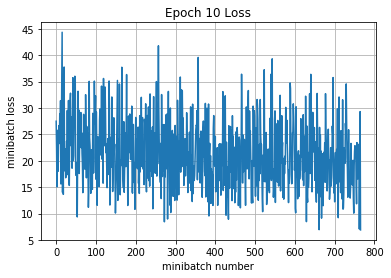

Validation
Epoch 1, Overall loss = 0.732 and accuracy of 0.795


(0.73213877916336056, 0.79500000000000004)

In [84]:
# Densenet model
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = Densenet(X,y,is_training)
mean_loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out))
optimizer = tf.train.AdamOptimizer()


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
    
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

In [85]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.365 and accuracy of 0.879
Validation
Epoch 1, Overall loss = 0.732 and accuracy of 0.795


(0.73213879394531245, 0.79500000000000004)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

- Model 1 is a basic cnn model that comprise 5 convolutional layers and one affine layer followed with dropout. Model 2 comprise two [batch-relu-conv] layers and one affine layer followed with dropout. Model 3 comprise two [conv-batch-relu] layers and one affine layer followed with dropout.

- Resnet model comprise 25 resunit layer, we downsampling height and width every 5 resunit using strided convolution. 
- Highwaynet has similar architecure to Resnet but it has more adaptive or learnable way for flows that goes through shortcut path.
- Densenet comprises dense block in which convolution layer has pathway to all convolution layers after. So once we go through a conv layer, we use tf.concat to concat every conv layer we visit before and apply conv filter and so on. 

The result of Highwaynet resnet beat most model above. Because after 10 epoch it got 91 % training accuracy and best validation accuracy, so i think if training with more epoch we can obtain better results but also need more computation time. Resnet archtecture provide shorcut both for forward and backeward course that reduced vanishing gradient issues maybe one of perspectives to improve the result.

However, Densenet maybe the best model since after 10 epochs its **validation accuracy achieve almost 80%! **and it still can gettig better if we train more time. The intuition of the architecture is that those bottom layers have directly contributions both to higher layers and classification layer. Also, it somehow alleviate gradient vanishing problem because there are skip pathways for backpropagation flows.

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [86]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 0.798 and accuracy of 0.768


(0.79751891641616823, 0.7681)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.